In [2]:
import numpy as np
import cv2
import os
from os.path import join
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json

# Load data

In [3]:
def read_data(path):
    n_class = 30
    data = []
    class_table = {}
    for i, class_ in enumerate(os.listdir(path)):
        class_table[i] = class_
        class_ = join(path, class_)
        imgs = [cv2.imread(join(class_, file)) for file in os.listdir(class_) if file[0] != '.']
        data.append(imgs)
    return data, class_table

data, class_table = read_data('./database')

# Evaluation
## Adopt cosine similarity

In [4]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_AP(similarity, cur_class):
    ## calculate AP
        total, correct = 0, 0
        AP = 0.0
        for j in range(len(similarity)):
            total += 1
            if similarity[j][1] == cur_class:
                correct += 1
                AP += correct / total
        AP /= correct
        return AP
        
def evaluate(feature):
    n = len(feature)
    cur_class = 0
    AP_class = []
    tmp_AP, count = 0.0, 0
    
    for i in range(n):
        similarity = []
        for j in range(n):
            if j == i:
                continue
            sim =  cosine_similarity(feature[i][0], feature[j][0])
            similarity.append([sim, feature[j][1]])
        similarity = sorted(similarity, key=lambda x: x[0], reverse=True)
        
        ap = get_AP(similarity, feature[i][1])

        if feature[i][1] != cur_class:
            AP = tmp_AP / count
            AP_class.append([AP, cur_class])
            # init class & AP
            cur_class = feature[i][1]
            tmp_AP = ap
            count = 1
        else:
            tmp_AP += ap
            count += 1
        
    ## output result
    MAP = 0.0
    AP_class = sorted(AP_class, key=lambda x:x[0], reverse=True)
    for i in range(len(AP_class)):
        print('Class: {a}, AP: {b}'.format(a = class_table[AP_class[i][1]], b = AP_class[i][0]))
        MAP += AP_class[i][0]
    MAP /= len(AP_class)
    print('MAP: {a}'.format(a = MAP))

# Color feature(global color histogram)

100%|██████████| 30/30 [00:00<00:00, 51.34it/s]


[Color feature]
Class: minnie_dress, AP: 0.535751135923954
Class: garment, AP: 0.40830261802750434
Class: baby_shoes, AP: 0.2946371648289428
Class: women_clothes, AP: 0.2679412669387301
Class: gge_snack, AP: 0.24526664536400636
Class: skirt, AP: 0.24475087012326818
Class: children_dress, AP: 0.23940282703596436
Class: ice_cream, AP: 0.2379100540547679
Class: men_clothes, AP: 0.2150720876265305
Class: goggles, AP: 0.20773058854231669
Class: korean_snack, AP: 0.1938750813826565
Class: nba_jersey, AP: 0.17224578859729206
Class: cup, AP: 0.1392245577457477
Class: sprite, AP: 0.13323143154086087
Class: trousers, AP: 0.12555787389479228
Class: bracelet, AP: 0.12455541764770901
Class: hand_cream, AP: 0.10669866425743871
Class: orange, AP: 0.10003244244978957
Class: leather_purse, AP: 0.09045793081804235
Class: bicycle, AP: 0.09016543140462008
Class: drum, AP: 0.09007153596726528
Class: tennis_ball, AP: 0.08694891929196083
Class: cartoon_purse, AP: 0.08305782071703445
Class: glasses, AP: 0.080

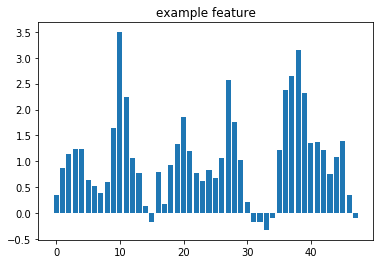

In [5]:
def color_histogram(data):
    feature = []
    for i in tqdm(range(len(data))):
        for j in range(len(data[i])):
            hist = []
            for channel in range(3):
                hist.extend(cv2.calcHist([data[i][j]], [channel], None, [16], [0, 256]))
            hist = np.array(hist)
            hist = hist.flatten()
            feature.append([hist, i])
    # normalize
    hist_features = np.array([f[0] for f in feature])
#     for i in range(len(hist_features[0])):
    mean = np.mean(hist_features, axis=0)
    std = np.std(hist_features, axis=0)
    hist_features = (hist_features - mean) / std
    for i in range(len(feature)):
        feature[i][0] = hist_features[i]
    return feature

# get features and evaluate
colorFeature = color_histogram(data)
print('[Color feature]')
evaluate(colorFeature)

# plot feature histogram - take 30th for example
plt.bar(np.arange(len(colorFeature[30][0])), colorFeature[30][0])
plt.title('example feature')
plt.show()

# Texture feature(Gabor texture)

In [5]:
def build_filters():
    filters = []
    ksize = [7, 9, 11, 13, 15] # gabor尺度 - 5個
    lamda = np.pi/2.0 # 波長
    for theta in np.arange(0, np.pi, np.pi / 4): # gabor方向 - 4個
        for K in ksize:
            kernel = cv2.getGaborKernel((K, K), 1.0, theta, lamda, 0.5, 0, ktype=cv2.CV_32F)
            kernel /= 1.5 * kernel.sum()
            filters.append(kernel)
    return filters

def process(img, filters):
    accum = np.zeros_like(img)
    for kernel in filters:
        filtered = cv2.filter2D(img, cv2.CV_8UC3, kernel)
        np.maximum(accum, filtered, accum)
    return accum

### Gabor feature extraction
def getGabor(img, filters):
    feature = []
    for i in range(len(filters)):
        tmp = process(img, filters[i])
        mean, std = np.mean(tmp), np.std(tmp)
        feature.append(mean)
        feature.append(std)
    feature = np.array(feature)
    return feature

def gabor_filter(data, filters):
    feature = []
    for i in tqdm(range(len(data))):
        for j in range(len(data[i])):
            feat = getGabor(data[i][j], filters)
            feature.append([feat, i])
    return feature

# retrieve features
filters = build_filters()
textFeature = gabor_filter(data, filters)

# save features
for i in range(len(textFeature)):
    textFeature[i][0] = textFeature[i][0].tolist()
with open('texture.json', 'w') as f:
    json.dump(textFeature, f)


100%|██████████| 30/30 [06:30<00:00, 13.02s/it]


[Texture feature]
Class: gge_snack, AP: 0.38839422014120006
Class: garment, AP: 0.35011594915712635
Class: cup, AP: 0.2144469168068941
Class: bracelet, AP: 0.208686864674796
Class: baby_shoes, AP: 0.20365347047324184
Class: goggles, AP: 0.2003067506093386
Class: women_clothes, AP: 0.1680000844254945
Class: minnie_dress, AP: 0.16742938891020723
Class: trousers, AP: 0.13855166399883473
Class: men_clothes, AP: 0.13721955691949056
Class: children_dress, AP: 0.1367738165535613
Class: leather_purse, AP: 0.13459998920225102
Class: skirt, AP: 0.1321229599863271
Class: korean_snack, AP: 0.1242371863427912
Class: orange, AP: 0.10669353274932927
Class: cartoon_purse, AP: 0.09293127791140456
Class: bicycle, AP: 0.08953616213804519
Class: ice_cream, AP: 0.08392549848273177
Class: chair, AP: 0.0835622331751158
Class: sprite, AP: 0.08102324687273235
Class: minnie_shoes, AP: 0.07300237233798512
Class: bottle, AP: 0.07053342005079229
Class: tennis_ball, AP: 0.06715580071137024
Class: aloe_vera_gel, AP:

[Texture feature]
Class: gge_snack, AP: 0.38839422014120006
Class: garment, AP: 0.35011594915712635
Class: cup, AP: 0.2144469168068941
Class: bracelet, AP: 0.208686864674796
Class: baby_shoes, AP: 0.20365347047324184
Class: goggles, AP: 0.2003067506093386
Class: women_clothes, AP: 0.1680000844254945
Class: minnie_dress, AP: 0.16742938891020723
Class: trousers, AP: 0.13855166399883473
Class: men_clothes, AP: 0.13721955691949056
Class: children_dress, AP: 0.1367738165535613
Class: leather_purse, AP: 0.13459998920225102
Class: skirt, AP: 0.1321229599863271
Class: korean_snack, AP: 0.1242371863427912
Class: orange, AP: 0.10669353274932927
Class: cartoon_purse, AP: 0.09293127791140456
Class: bicycle, AP: 0.08953616213804519
Class: ice_cream, AP: 0.08392549848273177
Class: chair, AP: 0.0835622331751158
Class: sprite, AP: 0.08102324687273235
Class: minnie_shoes, AP: 0.07300237233798512
Class: bottle, AP: 0.07053342005079229
Class: tennis_ball, AP: 0.06715580071137024
Class: aloe_vera_gel, AP:

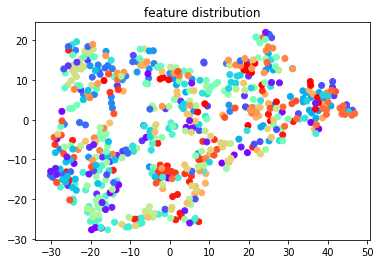

In [32]:
# load features
with open('texture.json', 'r') as f:
    textFeature = json.load(f)
    
# evaluate
print('[Texture feature]')
evaluate(textFeature)

# plot feature distribution
print('[Visualization]')
feature = np.array([ i[0] for i in textFeature])
label = [ i[1] for i in textFeature]
embedded = TSNE(n_components=2).fit_transform(feature)
# Init color map
cmap = cm.rainbow(np.linspace(0.0, 1.0, max(label)+1))
np.random.shuffle(cmap)
plt.scatter(embedded[:, 0], embedded[:, 1], marker='o', color=cmap[label[:]])
plt.title('feature distribution')
plt.show()

# Local feature(SIFT)

In [18]:
def getSift(img):
    # create sift and compute features
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=500)
    kp, features = sift.detectAndCompute(img, None)
    return features

def sift_with_kmeans_clustering(data):
    n_clusters = 256
    feature = []
    all_features = []
    for i in tqdm(range(len(data))):
        for j in range(len(data[i])):
            feat = getSift(data[i][j])
            feature.append([feat[n] for n in range(feat.shape[0])])
            for n in range(feat.shape[0]):
                all_features.append(feat[n])
    # apply kmeans clustering
    kmeans = KMeans(n_clusters=n_clusters).fit(all_features)
    return feature, kmeans

def retrieve_codebooks(feature, kmeans):
    cur = 0
    codebooks = []
    n_clusters = 256
    # retrieve codebook for each feature
    for i in tqdm(range(len(data))):
        for j in range(len(data[i])):
            tmp_feature = [0.0 for _ in range(n_clusters)]
            clusters = kmeans.predict(feature[cur])
            for n in range(clusters.shape[0]):
                tmp_feature[clusters[n]] += 1
            tmp_feature = [x / clusters.shape[0] for x in tmp_feature]
            codebooks.append([tmp_feature, i])
            cur += 1
    return codebooks

# retrieve features
localFeature, kmeans = sift_with_kmeans_clustering(data)
codebooks = retrieve_codebooks(localFeature, kmeans)

# save features
with open('localFeature.json', 'w') as f:
    json.dump(codebooks, f)

100%|██████████| 30/30 [00:01<00:00, 20.63it/s]


[Local feature]
Class: korean_snack, AP: 0.9947041314039643
Class: gge_snack, AP: 0.9848419437475412
Class: children_dress, AP: 0.5700753202764681
Class: aloe_vera_gel, AP: 0.5009824466501072
Class: chair, AP: 0.4987458003023598
Class: garment, AP: 0.48856379296429714
Class: baby_shoes, AP: 0.47063912106937844
Class: skirt, AP: 0.4236049159084292
Class: cartoon_purse, AP: 0.40798861091938854
Class: bracelet, AP: 0.38637126936541955
Class: hand_cream, AP: 0.29263753923550717
Class: minnie_dress, AP: 0.2755288686071308
Class: women_clothes, AP: 0.269973545693495
Class: men_clothes, AP: 0.2675741344751455
Class: clock, AP: 0.24454128735560535
Class: cup, AP: 0.19448046966520244
Class: ice_cream, AP: 0.1844223189727346
Class: drum, AP: 0.14859652532570305
Class: nba_jersey, AP: 0.11943863457827977
Class: minnie_shoes, AP: 0.11900969930372607
Class: orange, AP: 0.11089632145996889
Class: goggles, AP: 0.10820287898250744
Class: bicycle, AP: 0.09155162213982083
Class: sprite, AP: 0.0886673604

[Local feature]
Class: korean_snack, AP: 0.9947041314039643
Class: gge_snack, AP: 0.9848419437475412
Class: children_dress, AP: 0.5700753202764681
Class: aloe_vera_gel, AP: 0.5009824466501072
Class: chair, AP: 0.4987458003023598
Class: garment, AP: 0.48856379296429714
Class: baby_shoes, AP: 0.47063912106937844
Class: skirt, AP: 0.4236049159084292
Class: cartoon_purse, AP: 0.40798861091938854
Class: bracelet, AP: 0.38637126936541955
Class: hand_cream, AP: 0.29263753923550717
Class: minnie_dress, AP: 0.2755288686071308
Class: women_clothes, AP: 0.269973545693495
Class: men_clothes, AP: 0.2675741344751455
Class: clock, AP: 0.24454128735560535
Class: cup, AP: 0.19448046966520244
Class: ice_cream, AP: 0.1844223189727346
Class: drum, AP: 0.14859652532570305
Class: nba_jersey, AP: 0.11943863457827977
Class: minnie_shoes, AP: 0.11900969930372607
Class: orange, AP: 0.11089632145996889
Class: goggles, AP: 0.10820287898250744
Class: bicycle, AP: 0.09155162213982083
Class: sprite, AP: 0.0886673604

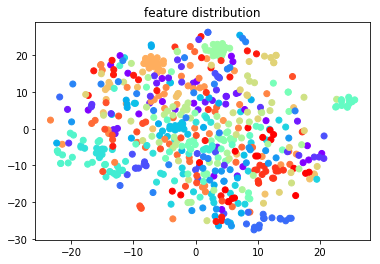

In [33]:
# load features
with open('localFeature.json', 'r') as f:
    localFeature = json.load(f)

# evaluate
print('[Local feature]')
evaluate(localFeature)

# plot feature distribution
print('[Visualization]')
feature = np.array([ i[0] for i in localFeature])
label = [ i[1] for i in localFeature]
embedded = TSNE(n_components=2).fit_transform(feature)
# Init color map
cmap = cm.rainbow(np.linspace(0.0, 1.0, max(label)+1))
np.random.shuffle(cmap)
plt.scatter(embedded[:, 0], embedded[:, 1], marker='o', color=cmap[label[:]])
plt.title('feature distribution')
plt.show()

# Results

categories<br/> vs. methods | MAP | Best Two Categories | Worst Two Categories
:---: | :---: | :---: | :---:
Color | 0.167 | minnie_dress(0.536), garment(0.408) | clock(0.061), aloe_vera_gel(0.048)
Texture | 0.130 | gge_snack(0.388), garment(0.35) | nba_jersey(0.0449), glasses(0.0445)
Local<br/> Feature | 0.296 | korean_snack(0.993), gge_snack(0.975) | tennis_ball(0.056), glasses(0.045)